In [56]:
import pandas as pd
import numpy as np
import glob
from collections import Counter
from nltk.corpus import stopwords
import os, sys, re, json, time, unittest
import itertools, collections
from scipy import stats
from subprocess import call
import nltk
from shared_lib import utils, vocabulary
import ngram_lm
import ngram_utils
import matplotlib.pyplot as plt
import datetime
import sys
sys.setdefaultencoding('utf-8')

# Download Data

In [2]:
def download_tweets(month_prefix, location, begin_day, end_day, max_tweets_per_day=2000):
    for i in xrange(begin_day, end_day):
        frmday = str(i)
        if i < 10:
            frmday = "0" + frmday
        today = str(i+1)
        if i+1 < 10:
            today = "0" + today
        frm = month_prefix+frmday
        until = month_prefix+today
        output_dir = 'data_'+location.replace(" ", "_")+ '/'
        call(['mkdir', output_dir])
        cmd = ["python", "Exporter.py", "--since", frm, "--until", until, "--near", location, "--maxtweets", str(max_tweets_per_day), "--output", output_dir + frm +".csv"]
        call(cmd)


In [3]:
download_tweets('2017-11-', 'Las Vegas', 12, 13, 500)

# Data Preparation

In [73]:
train_bin_size = 14
test_bin_size = 1

vegas_directory = 'data_Las_Vegas'
houston_directory = 'data_Houston'
san_juan_directory = 'data_San_Juan'
data_directories = [vegas_directory, houston_directory, san_juan_directory]

In [6]:
def get_train_and_tests(directory, train_size=21, test_size=3):
    allFiles = sorted(glob.glob(directory + "/*.csv"))
    train_frame = pd.DataFrame()
    train_list = []
    tests_list = []
    test_list = []
    tweet_column = 'text'
    test_files = []
    tests_files = []
    for index, file_ in enumerate(allFiles):
        df = pd.read_csv(file_,index_col=None, header=0, delimiter=';', error_bad_lines=False)
        if index < train_bin_size:
            #print "Adding {0} to training with {1} lines.".format(file_, len(df))
            train_list.append(df[tweet_column])
        elif (index + 1 - train_bin_size) % test_bin_size == 0:
            #print "Adding {0} to testing with {1} lines.".format(file_, len(df))
            test_list.append(df[tweet_column])
            test_files.append(file_)
            test_set = pd.concat(test_list, ignore_index=True).dropna()
            #print "Adding a test set to training with {0} lines.".format(len(test_set))
            tests_list.append(test_set)
            tests_files.append(test_files)
            test_list=[]
            test_files=[]
        else:
            #print "Adding {0} to testing with {1} lines.".format(file_, len(df))
            test_list.append(df[tweet_column])
            test_files.append(file_)

    train_frame = pd.concat(train_list, ignore_index=True).dropna()
    return (train_frame, tests_list, tests_files)

In [7]:
vegas_train, vegas_tests, vegas_test_files = get_train_and_tests(vegas_directory)
houston_train, houston_tests, houston_test_files = get_train_and_tests(houston_directory)
san_juan_train, san_juan_tests, san_juan_test_files = get_train_and_tests(san_juan_directory)

Skipping line 1755: expected 10 fields, saw 11

Skipping line 239: expected 10 fields, saw 11
Skipping line 1644: expected 10 fields, saw 11

Skipping line 296: expected 10 fields, saw 11

Skipping line 70: expected 10 fields, saw 11

Skipping line 489: expected 10 fields, saw 11

Skipping line 13: expected 10 fields, saw 11



In [32]:
vegas_train.head()

0    Congratulations to Mr. & Mrs. Clifford! Anothe...
1    #cloudwatcherextraordinaire @Las Vegas, Nevada...
2    We made a #realtor very happy with our #homest...
3    #Sammich with #flaminghotcheetos spread #lasve...
4    clear sky -> few clouds temperature up 91°F ->...
Name: text, dtype: object

## Filtering

In [18]:
from datetime import datetime
import string
from nltk.stem.lancaster import LancasterStemmer
from nltk.corpus import stopwords

#Sanitizes the text by removing front and end punctuation, 
#making words lower case, and removing any empty strings.
def get_text_sanitized(tweet):
    return ' '.join([w.lower().strip().rstrip(string.punctuation)\
        .lstrip(string.punctuation).strip()\
        for w in tweet.replace('\xe2\x80\xa6', '').split(" ")\
        if w.strip().rstrip(string.punctuation).strip()])

#Gets the text, clean it, make it lower case, stem the words, and split
#into a vector. Also, remove stop words.
def get_text_normalized(tweet):
    #Sanitize the text first.
    text = get_text_sanitized(tweet).split()
    
    #Remove the stop words.
    text = [t for t in text if t not in [stopwords.words('english')] ]

    return text
    
    #Stemmer gets upset at a lot of tweets
    #Create the stemmer.
    stemmer = LancasterStemmer()
    
    #Stem the words.
    return [stemmer.stem(t) for t in text]

def purge_urls(tweet):
    return re.sub('http[s]?://(www. )?(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', '', tweet)

def sanitize_dataset(dataset):
    sentences = []
    for sentence in dataset:
        sentences.append(get_text_normalized(purge_urls(sentence)))
    return sentences

# Trigram Model

In [8]:
def get_vocab_size(sentences):
    results = Counter()
    for sent in sentences:
        results.update(sent)
    return len(results)

In [9]:
def sents_to_tokens(vocab, sents):
    """Returns an flattened list of the words in the sentences, with padding for a trigram model."""
    padded_sentences = (["<s>", "<s>"] + s + ["</s>"] for s in sents)
    # This will canonicalize words, and replace anything not in vocab with <unk>
    return np.array([utils.canonicalize_word(w, wordset=vocab.wordset) 
                     for w in utils.flatten(padded_sentences)], dtype=object)

In [10]:
def build_model(train_tokens, addk=False, k=0.001, delta=0.75):
    # Uncomment the line below for the model you want to run.
    Model = ngram_lm.KNTrigramLM
    if addk:
        Model = ngram_lm.AddKTrigramLM
    t0 = time.time()
    print "Building trigram LM...",
    lm = Model(train_tokens)
    print "done in %.02f s" % (time.time() - t0)
    ngram_utils.print_stats(lm)
    lm.set_live_params(k = 0.001, delta=0.75)
    return lm

In [11]:
def get_perplexity(lm, tokens, train_or_test="Test"):
    #log_p_data, num_real_tokens = ngram_utils.score_seq(lm, train_tokens)
    #print "Train perplexity: %.02f" % (2**(-1*log_p_data/num_real_tokens))
    log_p_data, num_real_tokens = ngram_utils.score_seq(lm, tokens)
    perplexity = -1.0
    if num_real_tokens > 0:
        perplexity = (2**(-1*log_p_data/num_real_tokens))
    print "{0} perplexity: {1:.2f}".format(train_or_test, perplexity)
    return perplexity

In [12]:
def measure_perplexity_over_time(train_set, test_sets, test_files, addk=False):
    train_sents = sanitize_dataset(train_set)
    vocab = vocabulary.Vocabulary((utils.canonicalize_word(w) for w in utils.flatten(train_sents)), size=get_vocab_size(train_sents))
    print "Train set vocabulary: %d words" % vocab.size
    train_tokens = sents_to_tokens(vocab, train_sents)
    lm = build_model(train_tokens, addk)
    get_perplexity(lm, train_tokens, "Train")
    perplexities = []
    for idx, test_set in enumerate(test_sets):
        print "="*20
        print "Test set #{0} containing files:\n{1}".format(idx, test_files[idx])
        test_sents = sanitize_dataset(test_set)
        test_tokens = sents_to_tokens(vocab, test_sents)
        perplexities.append(get_perplexity(lm, test_tokens))
        print "="*20
    return perplexities

In [117]:
vegas_perplexities_addk = measure_perplexity_over_time(vegas_train, vegas_tests, vegas_test_files, addk=True)
houston_perplexities_addk = measure_perplexity_over_time(houston_train, houston_tests, houston_test_files, addk=True)
san_juan_perplexities_addk = measure_perplexity_over_time(san_juan_train, san_juan_tests, san_juan_test_files, addk=True)

Train set vocabulary: 14827 words
Building trigram LM... done in 0.85 s
=== N-gram Language Model stats ===
0 unique 1-grams
0 unique 2-grams
64159 unique 3-grams
Optimal memory usage (counts only): 1 MB
Train perplexity: 17.81
Test set #0 containing files:
['data_Las_Vegas/2017-09-24.csv']
Test perplexity: 3029.69
Test set #1 containing files:
['data_Las_Vegas/2017-09-25.csv']
Test perplexity: 1921.78
Test set #2 containing files:
['data_Las_Vegas/2017-09-26.csv']
Test perplexity: -1.00
Test set #3 containing files:
['data_Las_Vegas/2017-09-27.csv']
Test perplexity: 2517.33
Test set #4 containing files:
['data_Las_Vegas/2017-09-28.csv']
Test perplexity: 2000.48
Test set #5 containing files:
['data_Las_Vegas/2017-09-29.csv']
Test perplexity: -1.00
Test set #6 containing files:
['data_Las_Vegas/2017-09-30.csv']
Test perplexity: -1.00
Test set #7 containing files:
['data_Las_Vegas/2017-10-01.csv']
Test perplexity: 3396.82
Test set #8 containing files:
['data_Las_Vegas/2017-10-02.csv']
Te

In [118]:
all_perplexities = []
all_perplexities.append(vegas_perplexities_addk)
all_perplexities.append(houston_perplexities_addk)
all_perplexities.append(san_juan_perplexities_addk)

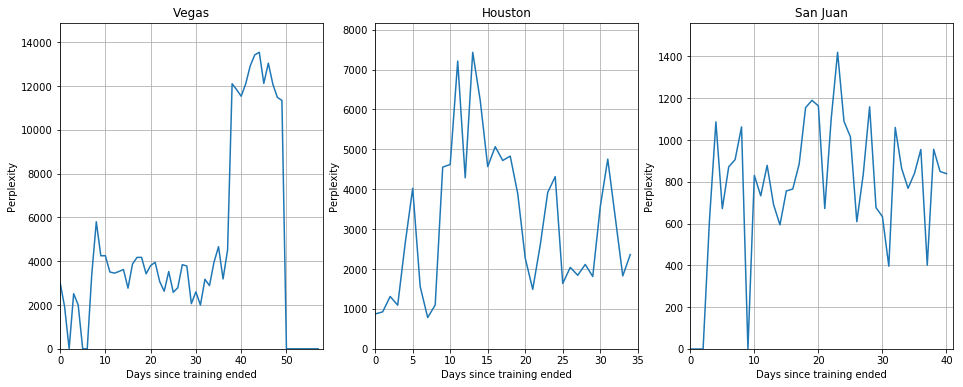

In [120]:
plt.figure(figsize=(16, 6))
events = ['Vegas', 'Houston', 'San Juan']
for i in range(len(events)):
    plt.subplot(131 + i)
    perp = all_perplexities[i]
    plt.plot(perp)
    plt.title(locations[i])
    plt.ylabel('Perplexity')
    plt.axis([0, len(perp), 0, 1.1 * max(perp)])
    plt.gca().set_xlabel("Days since training ended")
    plt.grid()
plt.show()

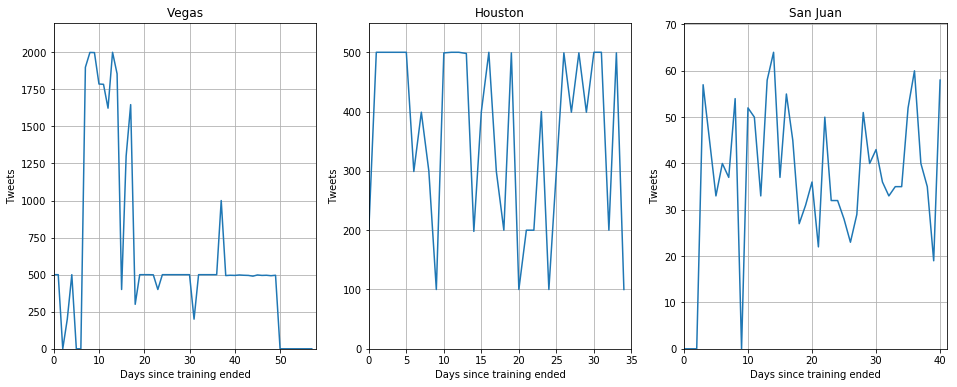

In [121]:
plt.figure(figsize=(16, 6))
events = ['Vegas', 'Houston', 'San Juan']
tests = [vegas_tests, houston_tests, san_juan_tests]
for i in range(len(events)):
    plt.subplot(131 + i)
    doc_count = [len(test_set) for test_set in tests[i]]
    plt.plot(doc_count)
    plt.title(locations[i])
    plt.ylabel('Tweets')
    plt.axis([0, len(doc_count), 0, 1.1 * max(doc_count)])
    plt.gca().set_xlabel("Days since training ended")
    plt.grid()
plt.show()

I need to download more data for these various parts to make sure that the test data sizes aren't affecting things.

In [19]:
get_vocab_size(sanitize_dataset(vegas_train))
len(vegas_train)

6499

In [34]:
def get_entire_dataframe(directory):
    allFiles = sorted(glob.glob(directory + "/*.csv"))
    train_frame = pd.DataFrame()
    train_list = []
    for index, file_ in enumerate(allFiles):
        df = pd.read_csv(file_,index_col=None, header=0, delimiter=';', error_bad_lines=False)
        train_list.append(df)
    train_frame = pd.concat(train_list, ignore_index=True)
    return train_frame

In [69]:
# setup train data
def get_raw_text(df):
    raw_text = ''
    for post in df['text']:
        raw_text = ' '.join([raw_text, str(post).decode('utf-8')])
    return raw_text

def get_word_freq_by_day(df, start_date, end_date, search_word):    
    
    word_counts = []
    
    while start_date <= end_date:
        sample_df = df[(df['date'].dt.date == start_date)]

        raw_sample_text = get_raw_text(sample_df)
        sample_words_list = nltk.word_tokenize(raw_sample_text)

        sample_vocab = vocabulary.Vocabulary((utils.canonicalize_word(w) for w in sample_words_list))

        word_counts.append([start_date, sample_vocab.unigram_counts[search_word]])

        start_date += datetime.timedelta(days=1)
    
    return word_counts

In [70]:
frame

,username,date,retweets,favorites,text,geo,mentions,hashtags,id,permalink
0,vegasjoker,2017-09-10 16:58:00,0.0,0.0,Congratulations to Mr. & Mrs. Clifford! Anothe...,NaN,NaN,NaN,9.070306e+17,https://twitter.com/vegasjoker/status/90703059...
1,Dalynol,2017-09-10 16:58:00,0.0,0.0,"#cloudwatcherextraordinaire @Las Vegas, Nevada...",NaN,@Las,#cloudwatcherextraordinaire,9.070306e+17,https://twitter.com/Dalynol/status/90703055429...
2,Stageasily,2017-09-10 16:58:00,0.0,3.0,We made a #realtor very happy with our #homest...,NaN,NaN,#realtor #homestaging #realestate #interiordesign,9.070306e+17,https://twitter.com/Stageasily/status/90703055...
3,scigeek64,2017-09-10 16:58:00,0.0,0.0,#Sammich with #flaminghotcheetos spread #lasve...,NaN,@,#Sammich #flaminghotcheetos #lasvegas #foodie ...,9.070305e+17,https://twitter.com/scigeek64/status/907030464...
4,NorthLasVegasNV,2017-09-10 16:58:00,0.0,0.0,clear sky -> few clouds temperature up 91°F ->...,NaN,NaN,NaN,9.070304e+17,https://twitter.com/NorthLasVegasNV/status/907...
5,destinydelish,2017-09-10 16:54:00,0.0,0.0,Blessed to have spent time with old friends an...,NaN,NaN,NaN,9.070295e+17,https://twitter.com/destinydelish/status/90702...
6,TheRealPAzAZz,2017-09-10 16:52:00,0.0,0.0,#PAzAZzStArChoreographer #THEREALPAZAZZ #pazaz...,NaN,@Las,#PAzAZzStArChoreographer #THEREALPAZAZZ #pazaz...,9.070290e+17,https://twitter.com/TheRealPAzAZz/status/90702...
7,Garz76,2017-09-10 16:51:00,0.0,0.0,Niners just just as bad with Hoyer at QB. It w...,NaN,NaN,NaN,9.070288e+17,https://twitter.com/Garz76/status/907028814940...
8,risspisskitty,2017-09-10 16:49:00,0.0,0.0,#sundayfunday #rehabpoolparty @Rehab Las Vegas...,NaN,@Rehab,#sundayfunday #rehabpoolparty,9.070283e+17,https://twitter.com/risspisskitty/status/90702...
9,JustAlliance,2017-09-10 16:49:00,0.0,1.0,Tracking...overdubs and background vocals toda...,NaN,NaN,#wherethewildthingsare #VocalLooping,9.070283e+17,https://twitter.com/JustAlliance/status/907028...


In [71]:
word = 'shooting'
frame = get_entire_dataframe('data_Las_Vegas')
word_counts = {}
start_date = datetime.date(2017, 9, 10)
end_date = datetime.date(2017, 10, 20)
frame['date'] = pd.to_datetime(frame['date'], coerce=True)
word_counts[word] = get_word_freq_by_day(frame, start_date, end_date, word)

In [72]:
word_counts['shooting']

[[datetime.date(2017, 9, 10), 2],
 [datetime.date(2017, 9, 11), 0],
 [datetime.date(2017, 9, 12), 0],
 [datetime.date(2017, 9, 13), 1],
 [datetime.date(2017, 9, 14), 3],
 [datetime.date(2017, 9, 15), 1],
 [datetime.date(2017, 9, 16), 0],
 [datetime.date(2017, 9, 17), 0],
 [datetime.date(2017, 9, 18), 2],
 [datetime.date(2017, 9, 19), 1],
 [datetime.date(2017, 9, 20), 0],
 [datetime.date(2017, 9, 21), 0],
 [datetime.date(2017, 9, 22), 2],
 [datetime.date(2017, 9, 23), 0],
 [datetime.date(2017, 9, 24), 2],
 [datetime.date(2017, 9, 25), 1],
 [datetime.date(2017, 9, 26), 0],
 [datetime.date(2017, 9, 27), 0],
 [datetime.date(2017, 9, 28), 1],
 [datetime.date(2017, 9, 29), 0],
 [datetime.date(2017, 9, 30), 2],
 [datetime.date(2017, 10, 1), 2],
 [datetime.date(2017, 10, 2), 69],
 [datetime.date(2017, 10, 3), 15],
 [datetime.date(2017, 10, 4), 15],
 [datetime.date(2017, 10, 5), 9],
 [datetime.date(2017, 10, 6), 7],
 [datetime.date(2017, 10, 7), 5],
 [datetime.date(2017, 10, 8), 5],
 [datetime.

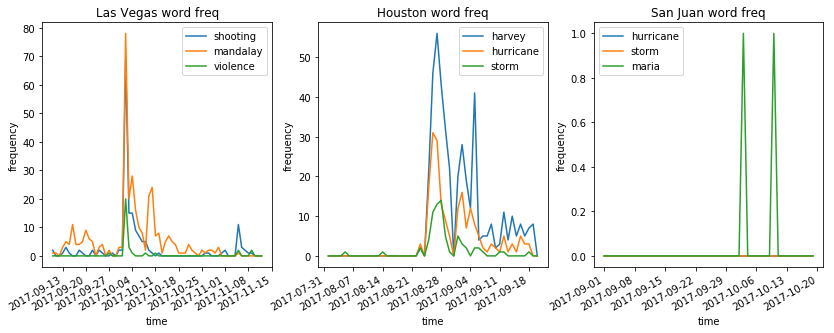

In [90]:
words = [['shooting', 'mandalay', 'violence'],['hurricane', 'storm', 'harvey'], ['hurricane', 'storm', 'maria']]
dates = [[datetime.date(2017, 9, 10), datetime.date(2017, 11, 12)], [datetime.date(2017, 8, 1), datetime.date(2017, 9, 20)], [datetime.date(2017, 9, 1), datetime.date(2017, 10, 19)]]
fig, ax = plt.subplots(1, 3, figsize=(14, 5))
for i in range(len(data_directories)):
    data_directory = data_directories[i]
    frame = get_entire_dataframe(data_directory)
    word_counts = {}
    frame['date'] = pd.to_datetime(frame['date'], coerce=True)
    for word in words[i]:
        word_counts[word] = get_word_freq_by_day(frame, dates[i][0], dates[i][1], word)
    
    for key in word_counts.keys():
        ax[i].plot(*zip(*word_counts[key]), label=key)
    ax[i].set_title(data_directory.replace('data_', '').replace('_', ' ') + ' word freq')
    ax[i].set_ylabel('frequency')
    ax[i].set_xlabel('time')
    ax[i].legend()

fig.autofmt_xdate()
fig

In [ ]:
fig, ax = plt.subplots(1, 3, figsize=(14, 5))

for key in word_counts.keys():
    ax[1].plot(*zip(*word_counts[key]), label=key)
ax[1].set_title('NYC word freq')
ax[1].set_ylabel('frequency')
ax[1].set_xlabel('time')
ax[1].legend()

fig.autofmt_xdate()